## App project

Goal: an app to identify images of guiña, colo colo y andino...

In [81]:
import fastbook
fastbook.setup_book()

In [82]:
from fastbook import *
from fastai.vision.widgets import *

## Download chilean wildcats images

We will search images on the web of the following chilean wildcats:
1. Guiña
1. Colo Colo
1. Andino

In [83]:
def search_images_bing(key, term, max_images: int = 100, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()    
    return L(search_results['value'])

In [84]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [45]:
#dest = 'images/pikachu.jpg'
#results = search_images_bing(key, 'pikcahu', 1)
#download_images(dest, urls=results.attrgot('contentUrl'))

In [85]:
wildcat_types = 'guiña','colo colo','andino'
path = Path('chilean_wildcats')

In [50]:
for o in wildcat_types:
    print(f'gato {o}')

gato guiña
gato colo colo
gato andino


In [51]:
for o in wildcat_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'gato {o}')
    download_images(dest, urls=results.attrgot('contentUrl'))


 Download of https://www.dogalize.com/wp-content/uploads/2019/05/gato-andino.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p chilean_wildcats/andino
$ cd chilean_wildcats/andino
$ wget -c https://www.dogalize.com/wp-content/uploads/2019/05/gato-andino.jpg
$ tar xf gato-andino.jpg
 And re-run your code once the download is successful



Check the images folder:

In [5]:
!ls ./chilean_wildcats

andino	colo colo  guiña


In [7]:
path = Path('chilean_wildcats')
fns = get_image_files(path)
fns

(#269) [Path('chilean_wildcats/colo colo/00000047.jpg'),Path('chilean_wildcats/colo colo/00000055.jpg'),Path('chilean_wildcats/colo colo/00000036.jpg'),Path('chilean_wildcats/colo colo/00000030.jpg'),Path('chilean_wildcats/colo colo/00000097.jpg'),Path('chilean_wildcats/colo colo/00000029.jpg'),Path('chilean_wildcats/colo colo/00000091.jpg'),Path('chilean_wildcats/colo colo/00000093.jpg'),Path('chilean_wildcats/colo colo/00000090.jpg'),Path('chilean_wildcats/colo colo/00000035.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#0) []

### Gato colocolo

Descargar imagenes utilizandola palabra `gato colo color` arroja demasiadas busquedas poco precisas.
Se volverá a descargar imagenes pero con la palabra `gato de las pampas` que revisando en google images entrega resultados un poco más precisos.

Descargaremos las imagenes en una carpeta aparte para no mesclarlas con las imagenes de la busqueda gato colo colo.

In [62]:
dest = (path/'de las pampas')
dest.mkdir(exist_ok=True)
results = search_images_bing(key, 'gato de las pampas')
download_images(dest, urls=results.attrgot('contentUrl'))

In [88]:
!ls ./chilean_wildcats

andino	colo colo  de las pampas  guiña


Check if any downloaded image is corrupted:

In [93]:
# don't read images from colo colo
fns = get_image_files(path, folders=['andino', 'de las pampas', 'guiña'])
fns

(#257) [Path('chilean_wildcats/andino/00000055.jpg'),Path('chilean_wildcats/andino/00000057.JPG'),Path('chilean_wildcats/andino/00000030.jpg'),Path('chilean_wildcats/andino/00000097.jpg'),Path('chilean_wildcats/andino/00000029.jpg'),Path('chilean_wildcats/andino/00000091.jpg'),Path('chilean_wildcats/andino/00000093.jpg'),Path('chilean_wildcats/andino/00000002.jpg'),Path('chilean_wildcats/andino/00000000.jpg'),Path('chilean_wildcats/andino/00000068.jpg')...]

In [95]:
failed = verify_images(fns)
failed

(#0) []

In [74]:
fns.remove()

(#341) [Path('chilean_wildcats/colo colo/00000047.jpg'),Path('chilean_wildcats/colo colo/00000055.jpg'),Path('chilean_wildcats/colo colo/00000036.jpg'),Path('chilean_wildcats/colo colo/00000030.jpg'),Path('chilean_wildcats/colo colo/00000097.jpg'),Path('chilean_wildcats/colo colo/00000029.jpg'),Path('chilean_wildcats/colo colo/00000091.jpg'),Path('chilean_wildcats/colo colo/00000093.jpg'),Path('chilean_wildcats/colo colo/00000090.jpg'),Path('chilean_wildcats/colo colo/00000035.jpg')...]

In [106]:
doc(parent_label)

In [113]:
parent_label(fns[0])

'andino'

In [173]:
!ls ./chilean_wildcats

andino	colo colo  de las pampas  guiña


In [174]:
!rm -r './chilean_wildcats/colo colo'

In [175]:
!ls ./chilean_wildcats

andino	de las pampas  guiña


## Train the model

In [178]:
!ls ./chilean_wildcats

andino	de las pampas  guiña


In [203]:
wildcats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [204]:
dls = wildcats.dataloaders(path)

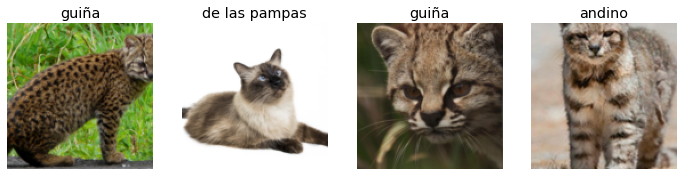

In [205]:
dls.valid.show_batch(max_n=4, nrows=1)

In [206]:
wildcats = wildcats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = wildcats.dataloaders(path)

In [207]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.674524,1.037521,0.416667,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.037740,0.908249,0.354167,00:04
1,0.981490,0.846841,0.208333,00:04
2,0.872178,0.824728,0.208333,00:05
3,0.784378,0.782633,0.166667,00:05


Interpreted results...

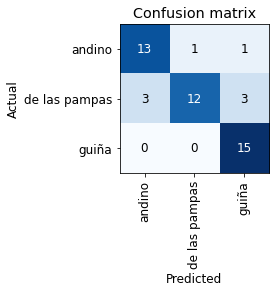

In [208]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

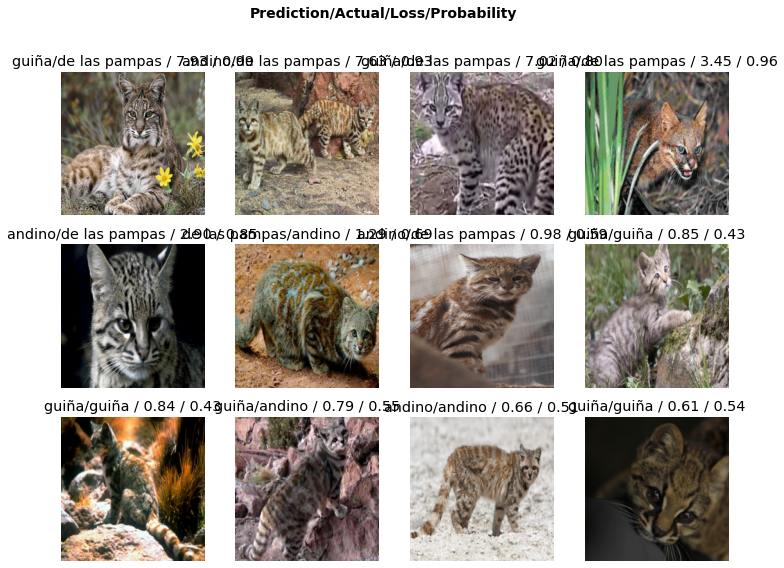

In [210]:
interp.plot_top_losses(12, nrows=3)

In [196]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [201]:
cleaner.delete()

(#1) [8]

In [202]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Save the model:

In [212]:
learn.export(fname='wildcat_model.pkl')

In [214]:
!ls . | find *.pkl

export.pkl
wildcat_model.pkl
